In [ ]:
# https://discuss.pytorch.org/t/i-have-3-gpu-why-torch-cuda-device-count-only-return-1/7245/4
import torch
import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())

print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

In [33]:
%load_ext autoreload
%autoreload 2

import os
import json

import torch
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

import wandb
wandb.login()
from pytorch_lightning.loggers import WandbLogger

from dataraw_sampling import sample_dataset, plot_sampled_distribution
from dataraw_full_matrix import gen_card_data, report_gamedata_distribution
from util_distribution import plot_distribution
from dataset import GameDatasetFromFullMatrix, GameTestFullDataset, GameDatasetTrainDataset
from datamodule import GameDataModule
from model import construct_full_model
from trainmodule import TrainModule

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Generation -- Full Matrix

In [2]:
num_attributes = 2
num_attr_vals = 3
game_data_full = gen_card_data(num_attributes=num_attributes, num_attr_vals=num_attr_vals, num_unseen_cardpairs=0, debug=False)

Generated 10 unqiue cards
Generated 81 cardpairs
-- 45 cardpairs with shared concept
-- 36 cardpairs without shared concept
Number of cardpairs per shared concept [(1, 36), (0, 36), (2, 9)]
Total number of matches =  189
Number of matches per key concept hit =  [(1, 144), (0, 36), (2, 9)]


{'shape': (10, 81), 'size': 810, 'sparsity': 0.23333333333333334, 'xy_rank': 10, 'xy_div_xyind_rank': 10}


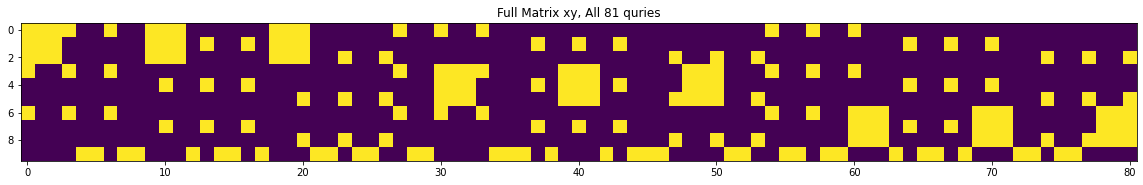

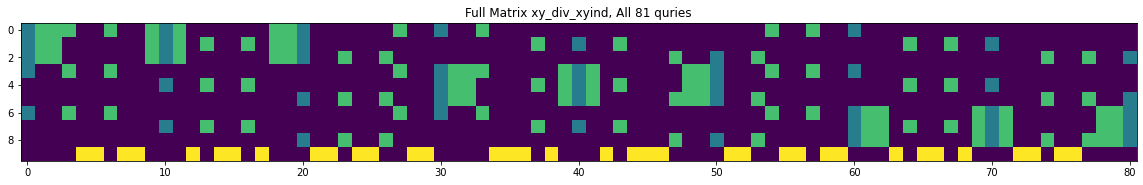

In [3]:
count_table, xy, _, xy_div_xyind, distribution = report_gamedata_distribution(game_data_full, distribution_epsilon=0.0)
print(distribution)
plot_distribution(xy, xy_div_xyind, dist_name='Full Matrix', figsize = (20,15))

## Data Generation -- Sampled

In [4]:
game_data_sampled = sample_dataset(num_attributes, num_attr_vals, N_train=1000, N_val=1000)

Sparsity Estimate: 0.23593252329833667
--- 0.14254498481750488 seconds ---


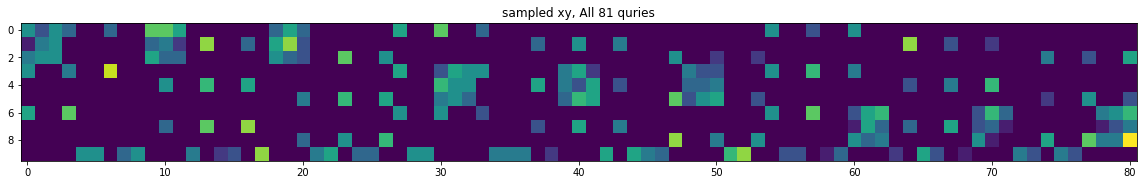

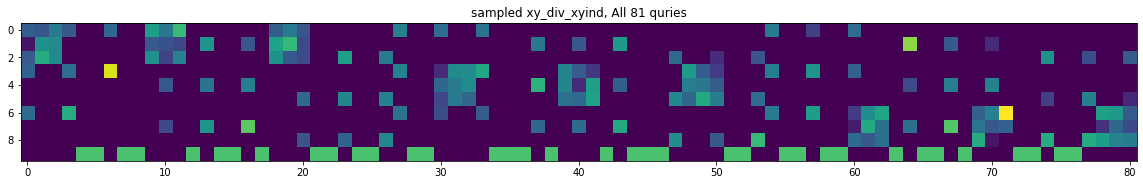

In [5]:
plot_sampled_distribution(game_data_sampled)

## Dataset

In [6]:
# From matrix
game_data_full = gen_card_data(num_attributes, num_attr_vals, num_unseen_cardpairs=0, debug=False)
print('------------------------------------------------------------------------')
game_dataset = GameDatasetFromFullMatrix(raw_data=game_data_full, debug=True)
game_dataset[50] 

Generated 10 unqiue cards
Generated 81 cardpairs
-- 45 cardpairs with shared concept
-- 36 cardpairs without shared concept
Number of cardpairs per shared concept [(1, 36), (0, 36), (2, 9)]
Total number of matches =  189
Number of matches per key concept hit =  [(1, 144), (0, 36), (2, 9)]
------------------------------------------------------------------------
query
 50 : 5 5 ('green', 'solid') ('green', 'solid')
key
 0 ('red', 'void')
all matches 
 [('red', 'solid'), ('green', 'void'), ('green', 'dashed'), ('green', 'solid'), ('blue', 'solid')]


(50, tensor([50]), tensor([0]), tensor([0, 0, 1, 1, 1, 1, 0, 0, 1, 0]))

In [7]:
# Sampled Train and Val
game_data_sampled = sample_dataset(num_attributes, num_attr_vals, N_train=10000, N_val=1000)
print('------------------------------------------------------------------------')
game_dataset_sampled = GameDatasetTrainDataset(raw_data=game_data_sampled, split='train', debug=True)
game_dataset_sampled[10]

Sparsity Estimate: 0.23211158236796017
--- 0.7614233493804932 seconds ---
------------------------------------------------------------------------
query
 47 : 5 2 [1 2] [0 2]
key
 8 [2 2]
all matches 
 [array([0, 2]), array([1, 2]), array([2, 2])]


(10, tensor([47]), tensor([8]), tensor([0, 0, 1, 0, 0, 1, 0, 0, 1, 0]))

In [8]:
# Test Full
print('------------------------------------------------------------------------')
game_dataset_sampled = GameTestFullDataset(raw_data=game_data_sampled, debug=True)
game_dataset_sampled[10]

------------------------------------------------------------------------
query
 10 : 1 1 [0 1] [0 1]
all matches 
 [array([0, 0]), array([0, 1]), array([0, 2]), array([1, 1]), array([2, 1])]


(10,
 tensor([10]),
 tensor([1262712832]),
 tensor([1, 1, 1, 0, 1, 0, 0, 1, 0, 0]))

## hparams, init train module

In [9]:
# arguments
generate_full_matrix = True
data_PATH = '../Raw_Datasets/2Attr-4Vals-2hat23Train-2hat3Val.json'
config_PATH = 'config.json'

In [10]:
# generate on the fly -- becareful of sampling time
# num_attributes = 2
# num_attr_vals = 3
# game_data = sample_dataset(num_attributes, num_attr_vals, N_train=10000, N_val=1000)

# read from disk instead
with open(data_PATH, 'r') as f:
    game_data = json.load(f)

print('----------data----------')
for k in game_data:
    if not 'datapoints' in k:
        print(k,':', game_data[k])
    else:
        print(k,'length :', len(game_data[k]))
print('------------------------')

----------data----------
num_attributes : 2
num_attr_vals : 4
key_support_size : 17
query_support_size : 256
train_datapoints length : 8388608
val_datapoints length : 8
------------------------


In [11]:
# read from disk instead
with open(config_PATH, 'r') as f:
    hparams = json.load(f)

hparams['key_support_size'] = game_data['key_support_size']
hparams['query_support_size'] = game_data['query_support_size']
hparams['num_attributes'] = game_data['num_attributes']
hparams['num_attr_vals'] = game_data['num_attr_vals']
hparams['populate_logits_matrix'] = generate_full_matrix
    
print('----------hparams----------')
for k in hparams:
    print(k, ':', hparams[k])
print('---------------------------')

----------hparams----------
seed : 42
batch_size : 128
max_epochs : 50
d_model : 8
embed_dropout : 0.0
dotproduct_bottleneck : True
loss_temperature_const : 1.0
lr : 0.001
adam_beta1 : 0.9
adam_beta2 : 0.999
adam_epsilon : 1e-08
warmup_steps : 12000
adam_weight_decay : 0
gradient_clip_val : 0
debug : False
key_support_size : 17
query_support_size : 256
num_attributes : 2
num_attr_vals : 4
populate_logits_matrix : True
---------------------------


In [14]:
# main() do this only if data is small
if generate_full_matrix:
    print('Generating Full Matrix')
    game_data_full = gen_card_data(hparams['num_attributes'], hparams['num_attr_vals'], num_unseen_cardpairs=0, debug=False)
    count_table, xy, xyind, xy_div_xyind, distribution = report_gamedata_distribution(game_data_full, distribution_epsilon=0.0)
    gt = {
        'count_table':count_table,
        'xy':xy,
        'xyind':xyind,
        'xy_div_xyind':xy_div_xyind,
        'distribution':distribution
    }
    print(distribution)
else:
    gt = None

Generating Full Matrix
Generated 17 unqiue cards
Generated 256 cardpairs
-- 112 cardpairs with shared concept
-- 144 cardpairs without shared concept
Number of cardpairs per shared concept [(0, 144), (1, 96), (2, 16)]
Total number of matches =  640
Number of matches per key concept hit =  [(1, 480), (0, 144), (2, 16)]
{'shape': (17, 256), 'size': 4352, 'sparsity': 0.14705882352941177, 'xy_rank': 17, 'xy_div_xyind_rank': 17}


In [19]:
# main()

pl.seed_everything(hparams['seed'])

# model
trainmodule =  TrainModule(hparams, gt_distributions=gt if hparams['populate_logits_matrix'] else {})
model_summary = pl.core.memory.ModelSummary(trainmodule, mode='full')
print(model_summary,'\n')

# dataset
game_datamodule = GameDataModule(
    batch_size = hparams['batch_size'],
    raw_data = game_data,
    debug=hparams['debug']
)

# testloader
test_loader = DataLoader(
            GameTestFullDataset(raw_data=game_data, debug=hparams['debug']), 
            batch_size=hparams['batch_size'], shuffle=False
        )

# logger
run_name = 'CardGame:OR;attr{}-val{};d_model{};{};params{}K'.format(
    num_attributes, num_attr_vals, 
    hparams['d_model'],  
    'dot-product' if hparams['dotproduct_bottleneck'] else '',
    round(max(model_summary.param_nums)/1000,2))
project_name = 'ContrastiveLearning-cardgame-Scaling-SecondPass'
wd_logger = WandbLogger(name=run_name, project=project_name)
print('RUN NAME :\n', run_name)

# check point path
ckpt_dir_PATH = os.path.join('checkpoints', project_name, run_name)
os.makedirs(ckpt_dir_PATH, exist_ok=True)

Global seed set to 42


   | Name                                         | Type               | Params
-------------------------------------------------------------------------------------
0  | model                                        | EncoderPredictor   | 2.2 K 
1  | model.inp_query_layer                        | Sequential         | 2.0 K 
2  | model.inp_query_layer.scaled_embed           | ScaledEmbedding    | 2.0 K 
3  | model.inp_query_layer.scaled_embed.embedding | Embedding          | 2.0 K 
4  | model.inp_query_layer.embed_dropout          | Dropout            | 0     
5  | model.inp_key_layer                          | Sequential         | 136   
6  | model.inp_key_layer.scaled_embed             | ScaledEmbedding    | 136   
7  | model.inp_key_layer.scaled_embed.embedding   | Embedding          | 136   
8  | loss_criterion                               | InfoCELoss         | 0     
9  | loss_criterion.CE_loss                       | CrossEntropyLoss   | 0     
10 | metrics                      

## run training

In [20]:
# train()
def run_train(trainmodule, datamodule, ckpt_dir_PATH, hparams, wd_logger):

    # checkpoints
    checkpoint_callback = ModelCheckpoint(
        monitor='avg_val_accuracy_by_Query',
        dirpath=ckpt_dir_PATH,
        filename='{epoch:02d}-{val_loss:.2f}',
        save_top_k=3,
        save_last=True,
        mode='max',
    )

    # trainer
    trainer = pl.Trainer(
        gpus=[1], 
        min_epochs=2, max_epochs=hparams['max_epochs'], 
        precision=32, 
        logger=wd_logger,
        log_gpu_memory='all',
        weights_summary = 'full',
        gradient_clip_val=hparams['gradient_clip_val'],
        callbacks=[checkpoint_callback]
    )

    #fit
    with torch.autograd.detect_anomaly():
        trainer.fit(trainmodule, datamodule)

    wandb.save(os.path.join(ckpt_dir_PATH, 'last.ckpt'))

In [23]:
# main()
run_train(trainmodule, game_datamodule, ckpt_dir_PATH, hparams, wd_logger)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
<ipython-input-20-8819e521c74f>:27: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



   | Name                                         | Type               | Params
-------------------------------------------------------------------------------------
0  | model                                        | EncoderPredictor   | 2.2 K 
1  | model.inp_query_layer                        | Sequential         | 2.0 K 
2  | model.inp_query_layer.scaled_embed           | ScaledEmbedding    | 2.0 K 
3  | model.inp_query_layer.scaled_embed.embedding | Embedding          | 2.0 K 
4  | model.inp_query_layer.embed_dropout          | Dropout            | 0     
5  | model.inp_key_layer                          | Sequential         | 136   
6  | model.inp_key_layer.scaled_embed             | ScaledEmbedding    | 136   
7  | model.inp_key_layer.scaled_embed.embedding   | Embedding          | 136   
8  | loss_criterion                               | InfoCELoss         | 0     
9  | loss_criterion.CE_loss                       | CrossEntropyLoss   | 0     
10 | metrics                     

Validation sanity check:   0%|          | 0/1 [00:00<?, ?it/s]

/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 0:   0%|          | 0/65537 [00:00<?, ?it/s]                    

/home/user/miniconda/lib/python3.8/site-packages/torch/cuda/memory.py:231: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The validation_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)
/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 0: 100%|██████████| 65537/65537 [1:34:59<00:00, 11.50it/s, loss=432, v_num=iuq3]
Validating: 0it [00:00, ?it/s]
Epoch 1:   3%|▎         | 2213/65537 [03:14<1:32:57, 11.35it/s, loss=432, v_num=iuq3] 

/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)
Saving latest checkpoint...


Epoch 1:   3%|▎         | 2213/65537 [03:15<1:33:01, 11.34it/s, loss=432, v_num=iuq3]


## resume training

In [ ]:
def resume_train(project_name, run_Id, trainmodule, datamodule, ckpt_dir_PATH, hparams, wd_logger):
    
    checkpoint_PATH = os.path.join(ckpt_dir_PATH, 'last.ckpt')
    run_PATH = os.path.join(project_name, run_Id) # also from wandb interface '1ih8yza5'

    wandb.restore(checkpoint_PATH, run_path=run_PATH)
    checkpoint = torch.load(checkpoint_PATH, map_location=lambda storage, loc: storage)
    trainmodule.load_state_dict(checkpoint['state_dict'])
 
    checkpoint_callback = ModelCheckpoint(
        monitor='avg_val_accuracy_by_Query',
        dirpath=ckpt_dir_PATH,
        filename='{epoch:02d}-{val_loss:.2f}',
        save_top_k=3,
        save_last=True,
        mode='max',
    )

    trainer = pl.Trainer(
        gpus=[1], 
        min_epochs=2, max_epochs=12000, 
        precision=32, 
        logger=wd_logger,
        log_gpu_memory='all',
        weights_summary = 'full',
        gradient_clip_val=hparams['gradient_clip_val'],
        replace_sampler_ddp=False,
        callbacks=[checkpoint_callback]
    )
    
    with torch.autograd.detect_anomaly():
        trainer.fit(trainmodule, datamodule)

    wandb.save(os.path.join(ckpt_dir_PATH, 'last.ckpt'))

In [ ]:
resume_train(project_name, '1ih8yza5', trainmodule, game_datamodule, ckpt_dir_PATH, hparams, wd_logger)

## run testing

In [25]:
def run_test(ckpt_name, project_name, run_Id, gt, test_loader, trainmodule, datamodule, ckpt_dir_PATH, hparams, wd_logger, gpu, figsize=(10,15)):

    checkpoint_PATH = os.path.join(ckpt_dir_PATH, ckpt_name) #'last.ckpt'
    checkpoint = torch.load(checkpoint_PATH, map_location=lambda storage, loc: storage)
    trainmodule.load_state_dict(checkpoint['state_dict'])

    trainer = pl.Trainer(
        gpus=[gpu], 
        min_epochs=1, max_epochs=1, 
        precision=32, 
        log_gpu_memory='all',
        weights_summary = 'full',
        gradient_clip_val=hparams['gradient_clip_val'],
    )
    
    test_loader = DataLoader(
                GameTestFullDataset(raw_data=game_data, debug=True), 
                batch_size=hparams['batch_size'], shuffle=False
            )
    
    res = trainer.test(model=trainmodule, test_dataloaders=test_loader)
    
    if hparams['populate_logits_matrix']:  
        model_distribution_res = trainmodule.pull_model_distribution(debug=hparams['debug'])
        print('xy_hat_rank:', model_distribution_res['xy_hat_rank'])
        print('xy_div_xyind_hat_rank:', model_distribution_res['xy_div_xyind_hat_rank'])
        print('mi_hat:', model_distribution_res['mi_hat'])
        print('mi_gt:', model_distribution_res['mi_gt'])
        print('kl_div:', model_distribution_res['kl_div'])
        
        plot_distribution(model_distribution_res['xy_hat'], model_distribution_res['xy_div_xyind_hat'], 'Model', figsize)
        plot_distribution(gt['xy'], gt['xy_div_xyind'],'Ground-Truth', figsize)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing:   0%|          | 0/2 [00:00<?, ?it/s]query
 0 : 0 0 [0 0] [0 0]
all matches 
 [array([0, 0]), array([0, 1]), array([0, 2]), array([0, 3]), array([1, 0]), array([2, 0]), array([3, 0])]
query
 1 : 0 1 [0 0] [0 1]
all matches 
 [array([0, 0]), array([0, 1]), array([0, 2]), array([0, 3])]
query
 2 : 0 2 [0 0] [0 2]
all matches 
 [array([0, 0]), array([0, 1]), array([0, 2]), array([0, 3])]
query
 3 : 0 3 [0 0] [0 3]
all matches 
 [array([0, 0]), array([0, 1]), array([0, 2]), array([0, 3])]
query
 4 : 0 4 [0 0] [1 0]
all matches 
 [array([0, 0]), array([1, 0]), array([2, 0]), array([3, 0])]
query
 5 : 0 5 [0 0] [1 1]
all matches 
 [array([], dtype=float64)]
query
 6 : 0 6 [0 0] [1 2]
all matches 
 [array([], dtype=float64)]
query
 7 : 0 7 [0 0] [1 3]
all matches 
 [array([], dtype=float64)]
query
 8 : 0 8 [0 0] [2 0]
all matches 
 [array([0, 0]), array([1, 0]), array([2, 0]), array([3, 0])]
query
 9 : 0 9 [0 0] [2 1]
all matches 
 [array([], dtype=float64)]
query
 10 : 0 10 [0 0] [2

all matches 
 [array([], dtype=float64)]
query
 121 : 7 9 [1 3] [2 1]
all matches 
 [array([], dtype=float64)]
query
 122 : 7 10 [1 3] [2 2]
all matches 
 [array([], dtype=float64)]
query
 123 : 7 11 [1 3] [2 3]
all matches 
 [array([0, 3]), array([1, 3]), array([2, 3]), array([3, 3])]
query
 124 : 7 12 [1 3] [3 0]
all matches 
 [array([], dtype=float64)]
query
 125 : 7 13 [1 3] [3 1]
all matches 
 [array([], dtype=float64)]
query
 126 : 7 14 [1 3] [3 2]
all matches 
 [array([], dtype=float64)]
query
 127 : 7 15 [1 3] [3 3]
all matches 
 [array([0, 3]), array([1, 3]), array([2, 3]), array([3, 3])]
Testing:  50%|█████     | 1/2 [00:00<00:00,  1.80it/s]query
 128 : 8 0 [2 0] [0 0]
all matches 
 [array([0, 0]), array([1, 0]), array([2, 0]), array([3, 0])]
query
 129 : 8 1 [2 0] [0 1]
all matches 
 [array([], dtype=float64)]
query
 130 : 8 2 [2 0] [0 2]
all matches 
 [array([], dtype=float64)]
query
 131 : 8 3 [2 0] [0 3]
all matches 
 [array([], dtype=float64)]
query
 132 : 8 4 [2 0] [1 0

query
 247 : 15 7 [3 3] [1 3]
all matches 
 [array([0, 3]), array([1, 3]), array([2, 3]), array([3, 3])]
query
 248 : 15 8 [3 3] [2 0]
all matches 
 [array([], dtype=float64)]
query
 249 : 15 9 [3 3] [2 1]
all matches 
 [array([], dtype=float64)]
query
 250 : 15 10 [3 3] [2 2]
all matches 
 [array([], dtype=float64)]
query
 251 : 15 11 [3 3] [2 3]
all matches 
 [array([0, 3]), array([1, 3]), array([2, 3]), array([3, 3])]
query
 252 : 15 12 [3 3] [3 0]
all matches 
 [array([3, 0]), array([3, 1]), array([3, 2]), array([3, 3])]
query
 253 : 15 13 [3 3] [3 1]
all matches 
 [array([3, 0]), array([3, 1]), array([3, 2]), array([3, 3])]
query
 254 : 15 14 [3 3] [3 2]
all matches 
 [array([3, 0]), array([3, 1]), array([3, 2]), array([3, 3])]
query
 255 : 15 15 [3 3] [3 3]
all matches 
 [array([0, 3]), array([1, 3]), array([2, 3]), array([3, 0]), array([3, 1]), array([3, 2]), array([3, 3])]
Testing: 100%|██████████| 2/2 [00:01<00:00,  1.75it/s]
---------------------------------------------------

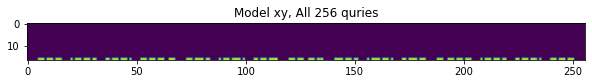

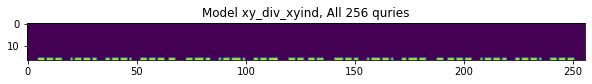

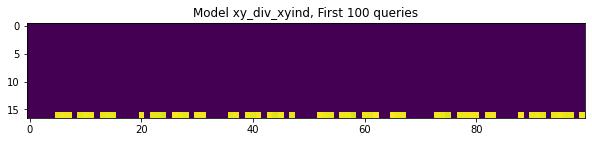

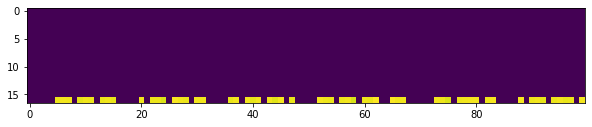

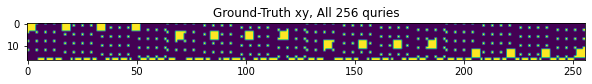

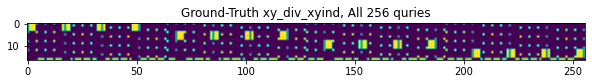

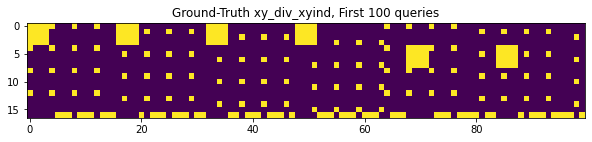

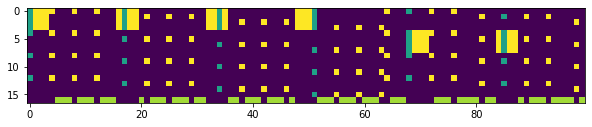

In [34]:
test_loader = DataLoader(
            GameTestFullDataset(raw_data=game_data, debug=True), 
            batch_size=hparams['batch_size'], shuffle=False
        )

run_test('last.ckpt', project_name, '1lygiuq3', gt, test_loader, trainmodule, game_datamodule, ckpt_dir_PATH, hparams, wd_logger, gpu=0, figsize=(10,15))